In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.style.use("seaborn-pastel")
plt.rcParams['figure.figsize'] = (10, 7)

In [3]:
with open('data/StreamingHistory0.json') as f:
    df = pd.DataFrame(json.load(f))

In [4]:
df

,endTime,artistName,trackName,msPlayed
0,2020-01-22 08:54,Ludwig van Beethoven,"String Quartet No. 14 in C-Sharp Minor, Op. 13...",244042
1,2020-01-22 09:00,Ludwig van Beethoven,"String Quartet No. 14 in C-Sharp Minor, Op. 13...",155099
2,2020-01-22 09:03,François Couperin,"Sœur Monique: 18ème ordre, 3ème livre",188100
3,2020-01-22 09:06,Ludwig van Beethoven,"Septet in E-Flat Major, Op. 20: III. Tempo di ...",189863
4,2020-01-22 09:09,Ludwig van Beethoven,"Piano Sonata No.20 in G Major, Op. 49 No.2: II...",180111
...,...,...,...,...
9590,2021-01-22 15:23,Primal Scream,Kill All Hippies,297350
9591,2021-01-22 15:28,Lalalar,İsyanlar - Radio Edit,280107
9592,2021-01-22 15:32,Caro,Closet Lunatic,246610
9593,2021-01-22 15:35,King Dude,Be Free,177861


In [5]:
df['endTime'] = df.endTime.apply(pd.Timestamp) + pd.offsets.DateOffset(hours=3)

<AxesSubplot:xlabel='endTime'>

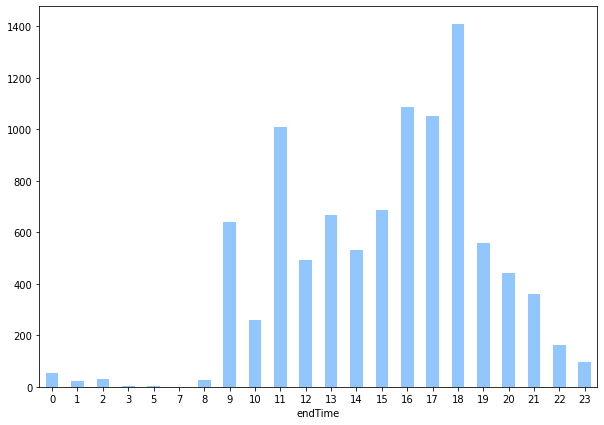

In [6]:
df.groupby(df.endTime.dt.hour)["endTime"].count().plot(kind='bar', rot=0)

In [7]:
@np.vectorize
def sort_key_day_of_week_names(name):
    return pd._libs.tslibs.fields.DAYS_FULL.index(name)

@np.vectorize
def sort_key_month_names(name):
    return pd._libs.tslibs.fields.MONTHS_FULL.index(name)

<AxesSubplot:xlabel='endTime'>

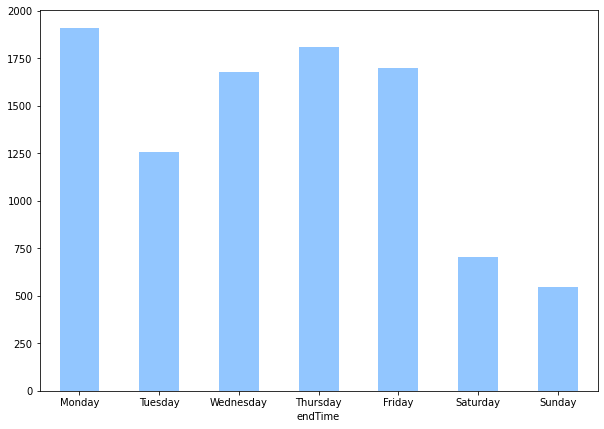

In [8]:
df.groupby(df.endTime.dt.day_name(locale='en_GB.UTF-8'))["endTime"].count()\
.sort_index(key=sort_key_day_of_week_names)\
.plot(kind='bar', rot=0)

<AxesSubplot:xlabel='endTime'>

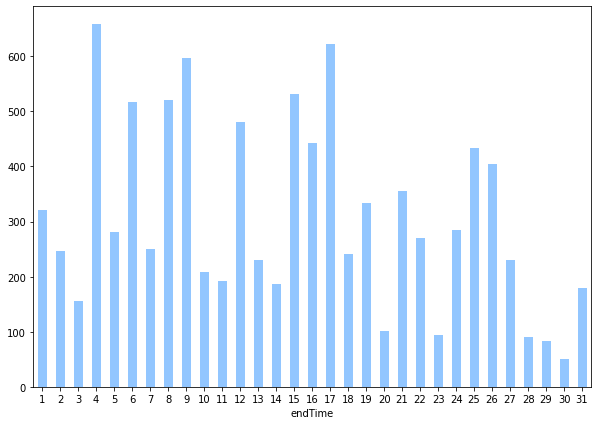

In [9]:
df.groupby(df.endTime.dt.day)["endTime"].count().plot(kind='bar', rot=0)

<AxesSubplot:xlabel='endTime'>

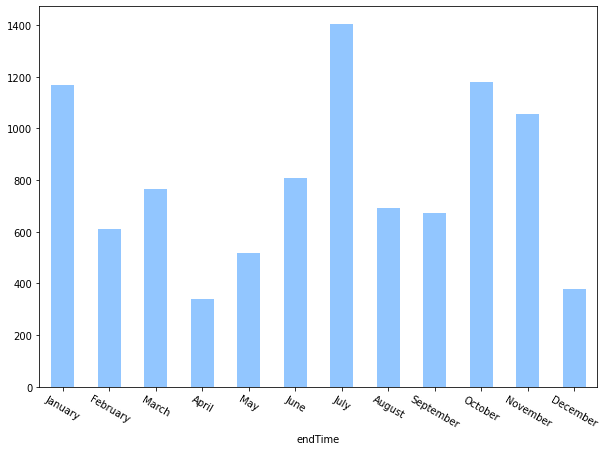

In [10]:
df.groupby(df.endTime.dt.month_name(locale='en_GB.UTF-8'))["endTime"].count()\
.sort_index(key=sort_key_month_names)\
.plot(kind='bar', rot=-30)